In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# https://joaquinamatrodrigo.github.io/skforecast/0.6.0/user_guides/autoregresive-forecaster-exogenous.html

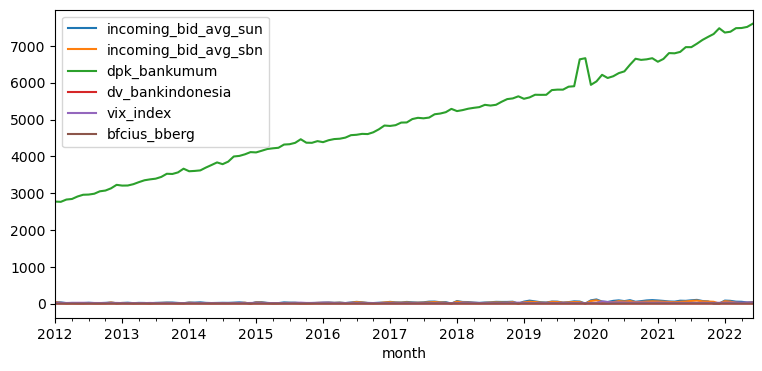

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/arifpras/forecastingDemand/main/20230126_database.csv')
data = pd.read_csv(url, sep=',', header=0, names=['month', 'incoming_bid_avg_sun', 'incoming_bid_avg_sbn', 'dpk_bankumum', 'dv_bankindonesia', 'vix_index', 'bfcius_bberg'])

# Data preprocessing
# ==============================================================================
data['month'] = pd.to_datetime(data['month'], format='%Y/%m/%d')
data = data.set_index('month')
data = data.asfreq('MS')
data = data.sort_index()

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

In [3]:
# Split train-test
# ==============================================================================
steps = 6
data_train = data.iloc[:-steps, :]
data_test  = data.iloc[-steps:, :]

In [9]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor = RandomForestRegressor(random_state=123),
                 lags      = 12
             )

forecaster.fit(
    y    = data_train['incoming_bid_avg_sun'],
    exog = data_train[['dpk_bankumum', 'dv_bankindonesia', 'vix_index']]
)

forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['dpk_bankumum', 'dv_bankindonesia', 'vix_index'] 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2021-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2023-01-27 09:07:56 
Last fit date: 2023-01-

In [10]:
# Predict
# ==============================================================================
steps = 6
predictions = forecaster.predict(
                steps = steps,
                exog = data_test[['dpk_bankumum', 'dv_bankindonesia', 'vix_index']]
              )
# Add datetime index to predictions
predictions = pd.Series(data=predictions, index=data_test.index)
predictions.head(6)

month
2022-01-01    38.499946
2022-02-01    38.994673
2022-03-01    29.054493
2022-04-01    28.092737
2022-05-01    31.902358
2022-06-01    25.018131
Freq: MS, Name: pred, dtype: float64

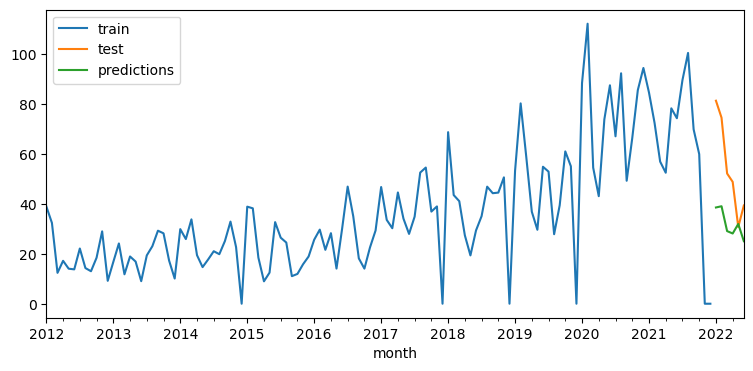

In [11]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data_train['incoming_bid_avg_sun'].plot(ax=ax, label='train')
data_test['incoming_bid_avg_sun'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [12]:
# Prediction error
# ==============================================================================
error_mse = mean_squared_error(
                y_true = data_test['incoming_bid_avg_sun'],
                y_pred = predictions
            )
print(f"Test error (mse): {error_mse}")

Test error (mse): 707.0191188911722


In [13]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.254462
1,lag_2,0.022336
2,lag_3,0.034807
3,lag_4,0.097794
4,lag_5,0.025747
5,lag_6,0.042160
6,lag_7,0.093864
7,lag_8,0.015550
8,lag_9,0.017465
9,lag_10,0.019776
